In [1]:
import trimesh
from pygem import FFD
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import plotly.graph_objects as go


def plot_mesh_c_points(mesh, ffd):
    control_points = ffd.control_points().T
    vertices = mesh.vertices

    # Create interactive 3D scatter plot
    fig = go.Figure()

    # Add main mesh points
    fig.add_trace(
        go.Scatter3d(
            x=vertices[:, 0],
            y=vertices[:, 1],
            z=vertices[:, 2],
            mode="markers",
            marker=dict(size=3, color="blue"),
            name="mesh",
        )
    )

    # Add control points
    fig.add_trace(
        go.Scatter3d(
            x=control_points[0, :],
            y=control_points[1, :],
            z=control_points[2, :],
            mode="markers",
            marker=dict(size=8, color="red"),
            name="control points",
        )
    )

    # Layout for axes
    fig.update_layout(
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
        width=700,
        height=700,
        title="Interactive 3D Scatter",
    )

    fig.show()

# Init Mesh

In [3]:
# Create an icosphere (triangular mesh approximation of a sphere)
mesh = trimesh.creation.icosphere(subdivisions=2, radius=1.0)
# Number of vertices and faces
print("Vertices:", len(mesh.vertices))
print("Faces:", len(mesh.faces))

mesh.show()

Vertices: 162
Faces: 320


# Compute drag

In [ ]:
from satopt.bla.drag import compute_drag, load_c_d_lookup_table, compute_aoa_and_area

In [5]:
lookup_t = load_c_d_lookup_table("aerodynamic_coefficients_panel_method.csv")

aoas, areas = compute_aoa_and_area(panels=mesh.faces, points=mesh.vertices)
print(aoas)

drag = compute_drag(aoas=aoas, areas=areas, lookup_table=lookup_t)

print(drag)

[np.float64(-34.2433233199229), np.float64(-44.87932229161718), np.float64(-26.938463753342), np.float64(-35.37726217845885), np.float64(-52.22842891448042), np.float64(-54.16958070892703), np.float64(-39.37211749463611), np.float64(-50.230832918073475), np.float64(-18.406350666497648), np.float64(-24.34513401411687), np.float64(-9.286082656577873), np.float64(-15.787168911034643), np.float64(-44.73469356155133), np.float64(-33.23789611278882), np.float64(-26.864588532078166), np.float64(-35.264389682754654), np.float64(-23.662256337133552), np.float64(-17.060642946905197), np.float64(-7.890428745205465), np.float64(-17.872080818446978), np.float64(-8.980866919837725), np.float64(-0.0), np.float64(8.980866919837721), np.float64(-0.0), np.float64(7.890428745205465), np.float64(17.060642946905205), np.float64(23.662256337133552), np.float64(17.872080818446978), np.float64(-8.957884899148977), np.float64(8.957884899148976), np.float64(-0.0), np.float64(-0.0), np.float64(-23.66225633713355

In [6]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [7]:
def plot_drag(mesh, aoas):
    # Plot comparison
    fig = plt.figure(figsize=(12, 5))

    # Second subplot: Surface colored by aoas
    ax2 = fig.add_subplot(111, projection="3d")

    # Create triangles for 3D plotting
    triangles = []
    colors = []
    for i, panel in enumerate(mesh.faces):
        # Get triangle vertices
        p1, p2, p3 = (
            mesh.vertices[panel[0]],
            mesh.vertices[panel[1]],
            mesh.vertices[panel[2]],
        )
        triangle = [p1, p2, p3]
        triangles.append(triangle)

        # Color based on aoas value
        aoa = aoas[i]
        # norme between 0 and 1 from -90 to 90 degrees
        aoa_normed = (aoa - np.min(aoas)) / (np.max(aoas) - np.min(aoas))

        color = plt.cm.viridis(aoa_normed)  # Use colormap to get color
        colors.append(color)

    # Create 3D polygon collection
    poly3d = Poly3DCollection(triangles, facecolors=colors, edgecolors="none")
    ax2.add_collection3d(poly3d)

    # Add colorbar for aoas values
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.viridis, norm=plt.Normalize(vmin=-90, vmax=90)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax2, shrink=0.5, aspect=10)
    cbar.set_label("AoA per Panel")

    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    plt.tight_layout()

    plt.show()

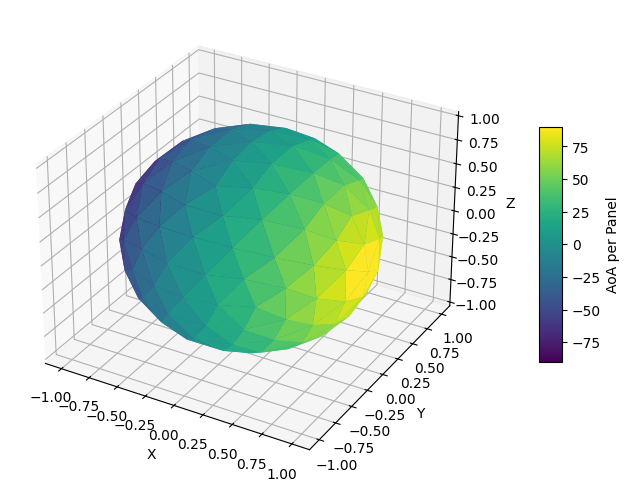

In [8]:
plot_drag(mesh, aoas)

# optimizer

In [9]:
from skopt import gp_minimize
from functools import partial


def objective_free(x, init_mesh, ffd, lookup_t):
    shape = list(ffd.array_mu_x.shape)
    shape.extend([3])
    x = np.array(x)
    x = x.reshape(shape)

    ffd.array_mu_x = x[:, :, :, 0]
    ffd.array_mu_y = x[:, :, :, 1]
    ffd.array_mu_z = x[:, :, :, 2]

    new_vertices = ffd(init_mesh.vertices)
    new_mesh = init_mesh
    new_mesh.vertices = new_vertices

    if new_mesh.volume < 3.5:
        return 10**2
    else:
        aoas, areas = compute_aoa_and_area(panels=mesh.faces, points=new_vertices)
        drag = compute_drag(aoas=aoas, areas=areas, lookup_table=lookup_t)
        return drag

    # aoas, areas = compute_aoa_and_area(panels=mesh.faces, points=new_vertices)
    # drag = compute_drag(aoas=aoas, areas=areas, lookup_table=lookup_t)

    return drag


def objective_x(x, init_mesh, ffd, lookup_t):
    shape = list(ffd.array_mu_x.shape)
    x = np.array(x)
    x = x.reshape(shape)

    ffd.array_mu_z = x[:, :, :]

    new_vertices = ffd(init_mesh.vertices)
    new_mesh = init_mesh
    new_mesh.vertices = new_vertices

    if new_mesh.volume < 3.5:
        return 10**2
    else:
        aoas, areas = compute_aoa_and_area(panels=mesh.faces, points=new_vertices)
        drag = compute_drag(aoas=aoas, areas=areas, lookup_table=lookup_t)
        return drag


objective_fn = {
    "free": objective_free,
    "x": objective_x,
}

In [ ]:
radius = 1
length = radius * 2.5

mesh = trimesh.creation.icosphere(subdivisions=2, radius=radius)

ffd = FFD([2, 2, 2])
ffd.box_length = [length, length, length]
ffd.box_origin = [-length / 2, -length / 2, -length / 2]

lookup_t = load_c_d_lookup_table("aerodynamic_coefficients_panel_method.csv")

fn = partial(objective_fn["x"], init_mesh=mesh, ffd=ffd, lookup_t=lookup_t)

x = [(0.0, 3.0)] * ffd.array_mu_x.flatten().shape[0]  # * 3

res = gp_minimize(fn, x, n_calls=100)
print(res.x, res.fun)

[2.2835257874739163, 1.3179193976539878, 1.2099530589932563, 0.14433524423747096, 1.5986806020361979, 1.4370749131363016, 0.3278045645221116, 0.4164696011589062] 100


In [11]:
def deform_mesh(x, init_mesh, ffd, lookup_t):
    shape = list(ffd.array_mu_x.shape)
    shape.extend([3])
    x = np.array(x)
    x = x.reshape(shape)

    ffd.array_mu_x = x[:, :, :, 0]
    ffd.array_mu_y = x[:, :, :, 1]
    ffd.array_mu_z = x[:, :, :, 2]

    new_vertices = ffd(init_mesh.vertices)
    init_mesh.vertices = new_vertices

    aoas, areas = compute_aoa_and_area(panels=mesh.faces, points=new_vertices)

    drag = compute_drag(aoas=aoas, areas=areas, lookup_table=lookup_t)

    return init_mesh, drag


def deform_mesh_x(x, init_mesh, ffd, lookup_t):
    shape = list(ffd.array_mu_x.shape)
    x = np.array(x)
    x = x.reshape(shape)

    ffd.array_mu_x = x[:, :, :]

    new_vertices = ffd(init_mesh.vertices)
    init_mesh.vertices = new_vertices

    return init_mesh, drag


deformatoin_fn = {
    "free": deform_mesh,
    "x": deform_mesh_x,
}

In [ ]:
mesh, drag = deformatoin_fn["x"](x=res.x, init_mesh=mesh, ffd=ffd, lookup_t=lookup_t)
mesh.show()
mesh.volume

np.float64(1.9181323825618517)

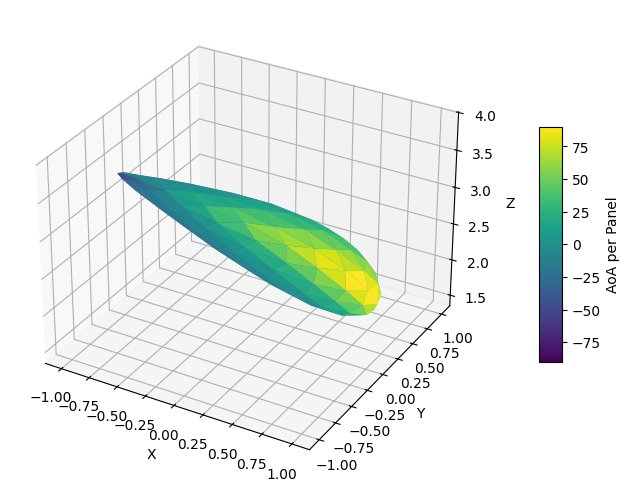

In [13]:
aoas, areas = compute_aoa_and_area(panels=mesh.faces, points=mesh.vertices)

plot_drag(mesh, aoas)

In [14]:
plot_mesh_c_points(mesh, ffd)

# Deform mesh

In [15]:
length = 4
ffd = FFD([2, 2, 2])
ffd.box_length = [length, length, length]
ffd.box_origin = [-length / 2, -length / 2, -length / 2]

print(ffd)

conversion_unit = 1.0
n_control_points = [2 2 2]

box_length = [4, 4, 4]
box_origin = [-2.0, -2.0, -2.0]
rot_angle  = [0. 0. 0.]

array_mu_x =
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]

array_mu_y =
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]

array_mu_z =
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]

rotation_matrix = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

position_vertices = [[-2. -2. -2.]
 [ 2. -2. -2.]
 [-2.  2. -2.]
 [-2. -2.  2.]]



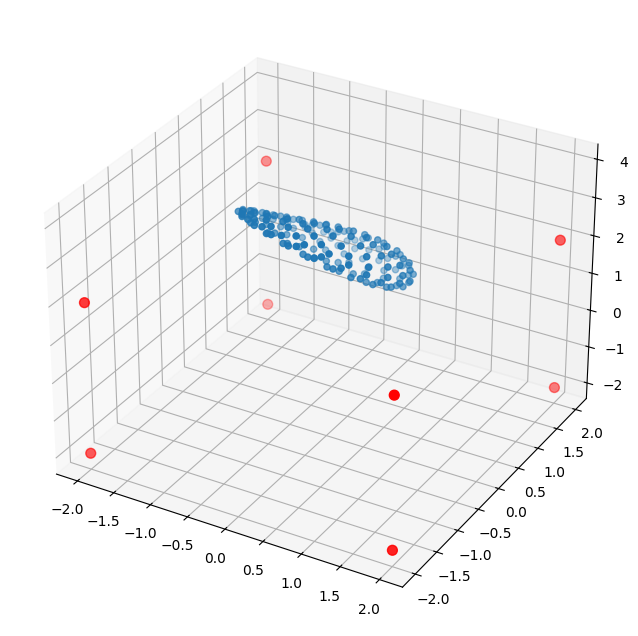

In [16]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111, projection="3d")
ax.scatter(*mesh.vertices.T)
ax.scatter(*ffd.control_points().T, s=50, c="red")
plt.show()

In [17]:
print(ffd.array_mu_x)
print(ffd.array_mu_x.shape)
print(ffd.array_mu_x.flatten().shape[0])

shape = list(ffd.array_mu_x.shape)
shape.extend([3])
print(shape)

x = [0] * ffd.array_mu_x.flatten().shape[0] * 3
x = np.array(x)
x.reshape(shape)

ffd.array_mu_x = x[:, :, :, 0]
ffd.array_mu_y = x[:, :, :, 1]
ffd.array_mu_z = x[:, :, :, 2]

[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
(2, 2, 2)
8
[2, 2, 2, 3]


IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

In [ ]:
print(
    "Movements of point[{}, {}, {}] along x: {}".format(
        1, 1, 1, ffd.array_mu_x[1, 1, 1]
    )
)
print(
    "Movements of point[{}, {}, {}] along z: {}".format(
        1, 1, 1, ffd.array_mu_z[1, 1, 1]
    )
)

# ffd.array_mu_x[1, 1, 1] = 0
# ffd.array_mu_z[1, 1, 1] = 0
# ffd.array_mu_y[1, 1, 1] = 0
# ffd.array_mu_x[1, 0, 1] = 0
# ffd.array_mu_z[1, 0, 1] = 0
ffd.array_mu_x[1, 0, 0] = 3.17
ffd.array_mu_x[0, 1, 0] = 1.96
ffd.array_mu_x[0, 0, 1] = 4.42
print()
print(
    "Movements of point[{}, {}, {}] along x: {}".format(
        1, 1, 1, ffd.array_mu_x[1, 1, 1]
    )
)
print(
    "Movements of point[{}, {}, {}] along z: {}".format(
        1, 1, 1, ffd.array_mu_z[1, 1, 1]
    )
)
print(ffd.array_mu_x)

In [ ]:
new_vertices = ffd(mesh.vertices)
control_points = ffd.control_points().T
print(type(new_vertices), new_vertices.shape)
print(type(control_points), control_points.shape)

In [ ]:
new_mesh = mesh
new_mesh.vertices = new_vertices

new_mesh.show()